In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

In [ ]:
# Define some constants

FIG_SIZE = (7.3,4.5)
LINESTYLE = (0,(4,4))
FONT_SIZE = 16
STEP = 5 # Percentile steps to report slow down on

BOLT_HDR_SIZE = 21. # Bytes
IP_HDR_SIZE = 20.   # Bytes
MTU = 5000.         # Bytes
PKT_PAYLOAD_SIZE = MTU - IP_HDR_SIZE - BOLT_HDR_SIZE

TOR_BW = 100e9  # bps
CORE_BW = 400e9 # bps

HOST_PER_TOR = 8.
TOR_PER_LEAF = 2.
LINK_DELAY = 315e-9 # 1e-6 #  seconds

PORT_START_NO = 1000

START_TIME = 1.0 # seconds
STOP_TIME = START_TIME + 0.1 # only consider flows that finish before this

SAVE_FIG = False

In [ ]:
workload = 'Google_RPC_read'
# workload = 'Facebook_Hadoop'
note = '' # Should start with a _
load = 0.8
simIdx = 0
nHost = 64
hpcc_utgt = 95
hpcc_ai = 50

trace_path = 'outputs/bolt-'+str(nHost)+'host-fattree/'
trace_path += workload + '_load-' + str(int(load*100)) + 'p'

hpcc_fct_file = trace_path + '_nHost-'+str(nHost)
hpcc_fct_file += '_HPCC-u'+str(hpcc_utgt)+'ai'+str(hpcc_ai)+'-fct.out'

trace_path += '_' + str(simIdx)
# trace_path += '_MSGAGG'

if TOR_BW == 100e9:
  rate_info = '_100G'
else:
  rate_info = ''

log_files = {
    'bolt' : trace_path + '_DEFAULT' + rate_info + note + '.tr',
    'swift': trace_path + '_SWIFT' + rate_info + '.tr'
}

In [ ]:
#@title
def remove_key(d, key):
    r = dict(d)
    del r[key]
    return r

In [ ]:
#@title
def get_pctl(a, p):
    i = int(len(a) * p)
    return a[i]

In [ ]:
#@title
def compute_baseRtt(sender,receiver):
    sndPort = sender.split(':')[1]
    sndIdx = int(sndPort) - PORT_START_NO
    sndTor = sndIdx // HOST_PER_TOR
    sndLeafGrp = sndTor // TOR_PER_LEAF
    
    rcvPort = receiver.split(':')[1]
    rcvIdx = int(rcvPort) - PORT_START_NO
    rcvTor = rcvIdx // HOST_PER_TOR
    rcvLeafGrp = rcvTor // TOR_PER_LEAF

    ackSize = IP_HDR_SIZE + BOLT_HDR_SIZE
    delay = 4. * LINK_DELAY + 2. * (MTU + ackSize) * 8. / TOR_BW
    if (sndTor == rcvTor):
        return delay
    
    delay += 4. * LINK_DELAY + 2. * (MTU + ackSize) * 8. / CORE_BW
    if (sndLeafGrp == rcvLeafGrp):
        return delay 

    delay += 4. * LINK_DELAY + 2.* (MTU + ackSize) * 8. / CORE_BW
    return delay

In [ ]:
#@title
def compute_slowDown(fct, baseRtt, msgSize):
    # translate to the minimum bytes required (with header)
    numPkts = math.ceil(msgSize / PKT_PAYLOAD_SIZE)
    totBytes = msgSize + numPkts * (IP_HDR_SIZE + BOLT_HDR_SIZE) 
    
    standaloneFct = baseRtt + totBytes * 8. / TOR_BW;
    return max(fct / standaloneFct, 1.0)

In [ ]:
#@title
msgStartLogs = {}
slowDownData = {}

for algo, log_filename in log_files.items():
  msgStartLogs[algo] = {}
  slowDownData[algo] = {}
  slowDownData[algo]['raw'] = []
  unfoundMsgCnt = 0

  with open(log_filename,'r') as f:
    for line in f:
      msgLog = line.split()

      time = float(msgLog[1])*1e-9        # in seconds
      msgSize = int(msgLog[2])            # in bytes
      sender = msgLog[3]                  # ip:port
      receiver = msgLog[4]                # ip:port
      txMsgId = int(msgLog[5])

      if (msgLog[0]=='+'):
        key = (sender, receiver, txMsgId)
        if (key in msgStartLogs[algo]):
          msgStartLogs[algo][key].append((time, msgSize))
        else:
          msgStartLogs[algo][key] = [(time, msgSize)]

      elif (msgLog[0] =='-' and time < STOP_TIME):
        key = (sender, receiver, txMsgId)
        if (key in msgStartLogs[algo]):
                    
          startTime, startedMsgSize = msgStartLogs[algo][key].pop()
          if (len(msgStartLogs[algo][key]) <= 0):
            msgStartLogs[algo] = remove_key(msgStartLogs[algo], key)

          baseRtt = compute_baseRtt(sender,receiver)
          slowDown = compute_slowDown(time - startTime, baseRtt, startedMsgSize)
          
          slowDownData[algo]['raw'].append((startedMsgSize, slowDown))
        else:
          print('ERROR: Start entry of message (' + str(msgSize) + ' ' \
                      + sender + ' ' + receiver + ' ' + str(txMsgId) \
                      + ') not found!')
          unfoundMsgCnt += 1

  slowDownData[algo]['raw'] = sorted(slowDownData[algo]['raw'])
  slowDownData[algo]['msgSizes'] = [x for x,_ in slowDownData[algo]['raw']]
  slowDownData[algo]['slowDowns'] = [x for _,x in slowDownData[algo]['raw']]

  print ('Number of messages whoose start entry is not found for {}: {}'.format(algo,unfoundMsgCnt))

Number of messages whoose start entry is not found for bolt: 0
Number of messages whoose start entry is not found for swift: 0


In [ ]:
#@title
for algo, data in slowDownData.items():

  slowDownData[algo]['res'] = [[i/100.] for i in range(0, 100, STEP)]
  nMsgs = len(data['msgSizes'])
  for i in range(0, 100, STEP):
      l = int(i * nMsgs / 100)
      r = int((i + STEP) * nMsgs / 100)
      msOfThisStep = data['msgSizes'][l:r]
      sdOfThisStep = sorted(data['slowDowns'][l:r])
      slowDownData[algo]['res'][int(i/STEP)].append(msOfThisStep[-1]) # flow size
      #slowDownData[algo]['res'][int(i/STEP)].append(sum(sdOfThisStep) / len(sdOfThisStep)) # avg fct
      slowDownData[algo]['res'][int(i/STEP)].append(get_pctl(sdOfThisStep, 0.5)) # mid fct
      slowDownData[algo]['res'][int(i/STEP)].append(get_pctl(sdOfThisStep, 0.9)) # 90-pct fct
      slowDownData[algo]['res'][int(i/STEP)].append(get_pctl(sdOfThisStep, 0.95)) # 95-pct fct
      slowDownData[algo]['res'][int(i/STEP)].append(get_pctl(sdOfThisStep, 0.99)) # 99-pct fct
      slowDownData[algo]['res'][int(i/STEP)].append(get_pctl(sdOfThisStep, 0.999)) # 99.9-pct fct

In [ ]:
#@title
slowDownData['hpcc'] = {}
slowDownData['hpcc']['res'] = []
with open(hpcc_fct_file, 'r') as f:
  for line in f:
    logs = line.split()
    slowDownData['hpcc']['res'].append([float(logs[0]), int(logs[1]), float(logs[2]), float(logs[3]), float(logs[4])])

In [ ]:
#@title
# for algo, data in slowDownData.items():
#   print('SlowDown Results of {}'.format(algo))
#   for line in data['res']:
#     print(line)

In [ ]:
#@title
# xticks_orig = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
shift = 1.0526
xticks_orig = [0.0*shift, 0.1*shift, 0.2*shift, 0.3*shift, 0.4*shift, 0.5*shift, 0.6*shift, 0.7*shift, 0.8*shift, 0.9*shift]
if (workload == 'Google_RPC_readBatch'):
  xticks = ['512','8K','16K','32K','34K','72K','240K', '700K', '1M', '10M']
  bdp = 0.56 - 0.1
elif (workload == 'Google_RPC_read'):
  xticks = ['512','4K','10K','23K','32K','46K','102K','262K', '1M', '16M']
  # bdp = 0.625 - 0.1
  bdp = (0.625 - 0.1) * shift
elif (workload == 'Facebook_Hadoop'):
  xticks = ['324','400','500','600','700','1K','7K', '46K', '120K', '10M']
  # bdp = 0.82 - 0.1
  bdp = (0.81 - 0.1) * shift
else:
  xticks = [x for _,x,_,_,_,_,_ in slowDownData['swift']['res']]
  bdp = None
  # Overwriting the xtick values for anonimity
xticks = ['10','20','30','40','50','60','70', '80', '90', '100']

Google_RPC_read - 


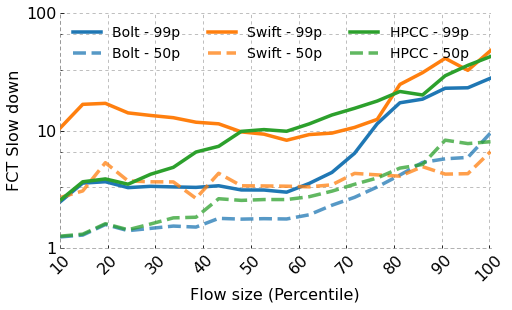

In [ ]:
#@title
print(workload + ' - ' + note)
plt.figure(figsize = FIG_SIZE)
  
percentiles = [x for x,_,_,_,_,_,_ in slowDownData['swift']['res']]

bolt_slowDowns_99p = [x for _,_,_,_,_,x,_ in slowDownData['bolt']['res']]
plt.plot(percentiles, bolt_slowDowns_99p, 
         label='Bolt - 99p', linewidth=3.5, color='C0')
bolt_slowDowns_50p = [x for _,_,x,_,_,_,_ in slowDownData['bolt']['res']]
plt.plot(percentiles, bolt_slowDowns_50p, 
         label='Bolt - 50p', linewidth=3.5, color='C0', linestyle='--', alpha=0.75)

# if (bdp):
#   plt.axvline(x=bdp, ymin=0.05, ymax=0.75, label='BDP', linewidth=3.5, color='C3')
#   # plt.plot(np.NaN, np.NaN, label=' ', color='none')

swift_slowDowns_99p = [x for _,_,_,_,_,x,_ in slowDownData['swift']['res']]
plt.plot(percentiles, swift_slowDowns_99p, 
         label='Swift - 99p', linewidth=3.5, color='C1')
swift_slowDowns_50p = [x for _,_,x,_,_,_,_ in slowDownData['swift']['res']]
plt.plot(percentiles, swift_slowDowns_50p, 
         label='Swift - 50p', linewidth=3.5, color='C1', linestyle='--', alpha=0.75)

hpcc_slowDowns_99p = [x for _,_,_,_,x in slowDownData['hpcc']['res']]
plt.plot(percentiles, hpcc_slowDowns_99p, 
         label='HPCC - 99p', linewidth=3.5, color='C2')
hpcc_slowDowns_50p = [x for _,_,x,_,_ in slowDownData['hpcc']['res']]
plt.plot(percentiles, hpcc_slowDowns_50p, 
         label='HPCC - 50p', linewidth=3.5, color='C2', linestyle='--', alpha=0.75)

plt.yscale('log')
plt.ylim([1,100])
yticks = [1,10,100]
plt.yticks(yticks, yticks, fontsize=FONT_SIZE)
plt.xlim([0,0.95])
plt.xticks(xticks_orig, xticks, rotation=45, fontsize=FONT_SIZE)

# plt.title('FCT Slow Down for Median and Tail', fontsize=FONT_SIZE)
plt.ylabel('FCT Slow down', fontsize=FONT_SIZE)
plt.xlabel('Flow size (Percentile)', fontsize=FONT_SIZE)
plt.legend(frameon=False, fontsize=FONT_SIZE-2, ncol=3, loc='upper left')

locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(1,3.3,6.6,10)) 
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.grid(axis='both', which='both', linestyle =LINESTYLE)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_linestyle(LINESTYLE)
plt.gca().spines["right"].set_alpha(0.75)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINESTYLE)
plt.gca().spines["left"].set_alpha(0.75)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINESTYLE)
plt.gca().spines["bottom"].set_alpha(0.75)
plt.gca().spines["bottom"].set_color('gray')
plt.tight_layout()

plt.gca().tick_params(axis="both", which='both', direction="in", 
                      left=True, labelleft=True)
if (SAVE_FIG):
  save_folder = '/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/'
  save_filename = 'fct_' + workload + '_load-' + str(int(load*100)) + 'p' + rate_info + note + '_without_bdp.pdf'
  plt.savefig(save_folder + save_filename)
plt.show()